Veri başarıyla yüklendi.
Model A: Random Forest Eğitiliyor...
Model B: Polinom Regresyon Eğitiliyor (Derece 2)...

MODELLERİN KARŞILAŞTIRMALI DEĞERLENDİRMESİ (Orijinal Euro Ölçeği)
| Model                            |   R-Kare (R^2) | Ort. Mutlak Hata (MAE)   | RMSE        |
|:---------------------------------|---------------:|:-------------------------|:------------|
| Random Forest Regressor          |         0.778  | 212.16 Euro              | 335.80 Euro |
| Polynomial Regression (Degree 2) |         0.6524 | 244.14 Euro              | 420.20 Euro |


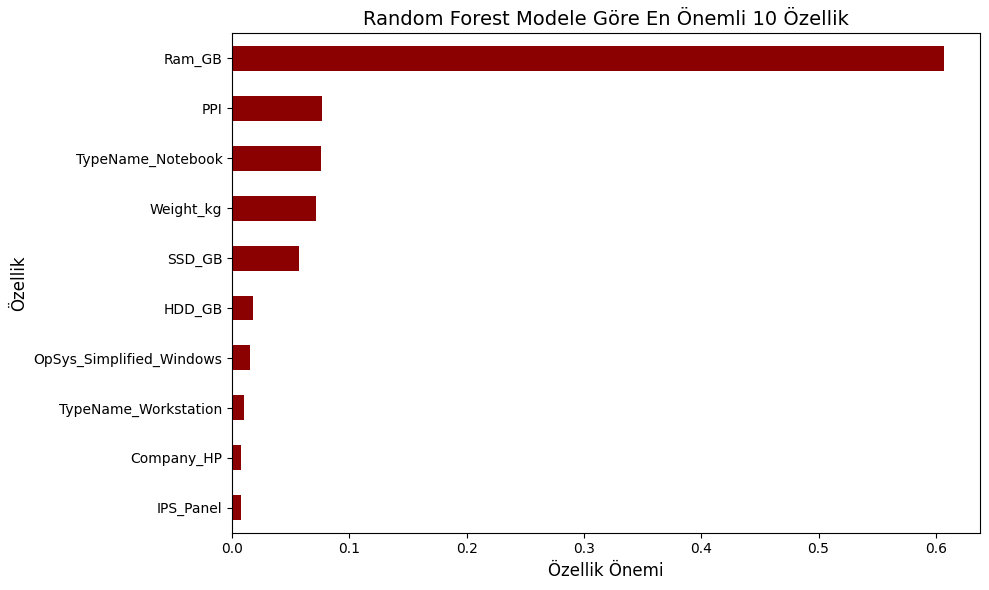

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. VERİ YÜKLEME ---
try:
    # UnicodeDecodeError'u çözmek için latin-1 kodlaması kullanılır.
    df = pd.read_csv('laptop_price_data.csv', encoding='latin-1')
    print("Veri başarıyla yüklendi.")
except FileNotFoundError:
    print("HATA: 'laptop_price_data.csv' dosyası bulunamadı.")
    exit()

# --- 2. VERİ TEMİZLİĞİ VE ÖZELLİK MÜHENDİSLİĞİ ---

# RAM ve Weight sütunlarını sayısal hale getirme
df.loc[:, 'Ram_GB'] = df['Ram'].str.replace('GB', '').astype(int)
df.loc[:, 'Weight_kg'] = df['Weight'].str.replace('kg', '').astype(float)
df.drop(columns=['Ram', 'Weight', 'Product', 'laptop_ID'], inplace=True)


# 3.1. ScreenResolution Özellikleri (Touchscreen, IPS Panel ve PPI)
df.loc[:, 'Touchscreen'] = df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
df.loc[:, 'IPS_Panel'] = df['ScreenResolution'].apply(lambda x: 1 if 'IPS Panel' in x else 0)
resolution_match = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)')

# Çözünürlük değerlerini ve Inches değerini güvenli şekilde alıp PPI hesaplama
df.loc[:, 'Resolution_W'] = resolution_match[0].fillna(0).astype(float)
df.loc[:, 'Resolution_H'] = resolution_match[1].fillna(0).astype(float)
df.loc[:, 'Inches'] = df['Inches'].fillna(df['Inches'].mean())
df.loc[:, 'PPI'] = np.sqrt(df['Resolution_W']**2 + df['Resolution_H']**2) / df['Inches']
df.drop(columns=['ScreenResolution', 'Resolution_W', 'Resolution_H', 'Inches'], inplace=True)


# 3.2. Memory (Depolama) Özellikleri (SSD ve HDD Kapasiteleri)
def clean_memory_capacity(memory):
    """Karmaşık Memory sütunundan SSD ve HDD kapasitelerini (GB) ayıklar."""
    memory = str(memory).replace(' ', '').replace('.', '')
    ssd_val, hdd_val = 0.0, 0.0

    def to_gb(capacity_str, unit):
        try:
            capacity = float(capacity_str)
            return capacity * 1024 if unit == 'TB' else capacity
        except ValueError:
            return 0.0

    parts = [memory]
    if '+' in memory:
        parts = memory.split('+')

    for part in parts:
        # SSD, Flash Storage, Hybrid (3 yakalama grubu)
        ssd_match = pd.Series(part).str.extract(r'(\d+\.?\d*)\s*(GB|TB)?\s*(SSD|FlashStorage|Hybrid)', expand=False).dropna(how='all')
        if not ssd_match.isnull().all().all():
            match_row = ssd_match.iloc[0]
            cap_str = match_row.iloc[0]
            unit = match_row.iloc[1] if pd.notna(match_row.iloc[1]) else 'GB'
            ssd_val += to_gb(cap_str, unit)

        # HDD Yakalama (2 yakalama grubu)
        hdd_match = pd.Series(part).str.extract(r'(\d+\.?\d*)\s*(GB|TB)\s*HDD', expand=False).dropna()
        if not hdd_match.empty:
            cap_str, unit = hdd_match.iloc[0]
            hdd_val += to_gb(cap_str, unit)

    return pd.Series([ssd_val, hdd_val])

df[['SSD_GB', 'HDD_GB']] = df['Memory'].apply(clean_memory_capacity)
df.drop(columns=['Memory'], inplace=True)


# 3.3. Kategorik Özellikleri Basitleştirme
df.loc[:, 'Cpu_Brand'] = df['Cpu'].apply(lambda x: x.split(' ')[0])
df.loc[:, 'Gpu_Brand'] = df['Gpu'].apply(lambda x: x.split(' ')[0])

def simplify_os(os):
    if 'Windows' in os:
        return 'Windows'
    elif 'macOS' in os or 'Mac OS' in os:
        return 'Mac'
    elif 'Linux' in os:
        return 'Linux'
    else:
        return 'Other/No OS'

df.loc[:, 'OpSys_Simplified'] = df['OpSys'].apply(simplify_os)
df.drop(columns=['Cpu', 'Gpu', 'OpSys'], inplace=True)


# --- 4. MODEL İÇİN SON HAZIRLIK ---

# 4.1. Hedef Değişken (Fiyat) Dönüşümü (LOG DÖNÜŞÜMÜ)
df.loc[:, 'log_Price'] = np.log(df['Price_euros'])
df.drop('Price_euros', axis=1, inplace=True)

# 4.2. Kategorik Sütunları One-Hot Encoding ile Sayısal Hale Getirme
categorical_cols = ['Company', 'TypeName', 'Cpu_Brand', 'Gpu_Brand', 'OpSys_Simplified']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


# 4.3. TÜM SÜTUNLARI SAYISAL HALE GETİRME (Kritik Güvenlik Adımı)
# Hata veren ' ' gibi stringleri NaN'e dönüştürür.
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 4.4. Eksik Değerleri Doldurma
df.fillna(0, inplace=True)


# --- 5. MODELLERİN EĞİTİMİ ---

# Veri Bölme
X = df.drop('log_Price', axis=1) # Özellikler (Features)
y = df['log_Price']              # Hedef Değişken (Target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# --- 5.1. MODEL A: RANDOM FOREST REGRESYONU (Ağaç Tabanlı) ---
print("Model A: Random Forest Eğitiliyor...")
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_leaf=1)
model_rf.fit(X_train, y_train)
y_pred_log_rf = model_rf.predict(X_test)


# --- 5.2. MODEL B: POLİNOM REGRESYON (Derece 2) ---
print("Model B: Polinom Regresyon Eğitiliyor (Derece 2)...")
# Kabak projesine benzer şekilde Polinom Regresyonu (Derece 2) Pipelines ile uygulanır.
poly_pipeline = make_pipeline(PolynomialFeatures(2, include_bias=False), LinearRegression())
poly_pipeline.fit(X_train, y_train)
y_pred_log_poly = poly_pipeline.predict(X_test)


# --- 6. SONUÇLARIN KARŞILAŞTIRMALI DEĞERLENDİRİLMESİ ---

# Orijinal ölçekte sonuçları hesaplama (ters log dönüşümü)

# Random Forest Metrikleri
y_test_original_rf = np.exp(y_test)
y_pred_original_rf = np.exp(y_pred_log_rf)
r2_rf = r2_score(y_test_original_rf, y_pred_original_rf)
mae_rf = mean_absolute_error(y_test_original_rf, y_pred_original_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_original_rf, y_pred_original_rf))

# Polinom Regresyon Metrikleri
y_test_original_poly = np.exp(y_test)
y_pred_original_poly = np.exp(y_pred_log_poly)
r2_poly = r2_score(y_test_original_poly, y_pred_original_poly)
mae_poly = mean_absolute_error(y_test_original_poly, y_pred_original_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test_original_poly, y_pred_original_poly))


print("\n" + "="*70)
print("MODELLERİN KARŞILAŞTIRMALI DEĞERLENDİRMESİ (Orijinal Euro Ölçeği)")
print("="*70)

results = pd.DataFrame({
    'Model': ['Random Forest Regressor', 'Polynomial Regression (Degree 2)'],
    'R-Kare (R^2)': [f'{r2_rf:.4f}', f'{r2_poly:.4f}'],
    'Ort. Mutlak Hata (MAE)': [f'{mae_rf:.2f} Euro', f'{mae_poly:.2f} Euro'],
    'RMSE': [f'{rmse_rf:.2f} Euro', f'{rmse_poly:.2f} Euro']
})

print(results.to_markdown(index=False))
print("="*70)

# --- 7. GÖRSELLEŞTİRME (Sadece en iyi model olan RF için) ---
feature_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
top_10_features = feature_importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_10_features.sort_values(ascending=True).plot(kind='barh', color='darkred')
plt.title('Random Forest Modele Göre En Önemli 10 Özellik', fontsize=14)
plt.xlabel('Özellik Önemi', fontsize=12)
plt.ylabel('Özellik', fontsize=12)
plt.tight_layout()
plt.show()